In [1]:
import gym
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np 
import pandas as pd


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [ ]:
# Create the CartPole-v1 environment with RGB array rendering for visualization
env = gym.make("CartPole-v1", render_mode="rgb_array")

# Reset the environment to get the initial observation (state)
obs = env.reset() # starting environment or initial state

# Print the initial observation/state vector
print(obs)

(array([0.01395135, 0.03914344, 0.04679792, 0.00747774], dtype=float32), {})


## Understanding the Problem

### Goal
* keep the pole upright by accelerating the cart attached to the pole above it

### State 
* horizontal position (where 0.0 = center)
* velocity (+ means right)
* angle of pole (0.0 means pole is vertical)
* angular velocity (+ means clockwise)

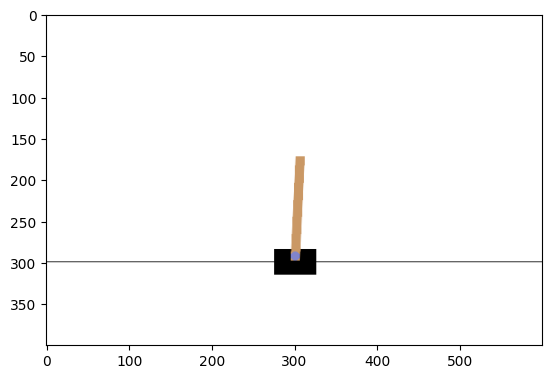

In [4]:
# INITIAL STATE
img = env.render()
plt.imshow(img)

### Actions

In [5]:
'''''
Dicrete(2) means that the possible actions are integer 0 & 1
'''''
env.action_space

Discrete(2)

#### Testing the Actions

* 0: to the right
* 1: to the left

In [6]:
action = 1
obs, reward, done, _, info= env.step(action)
print(f"Observation: {obs}")
print(f"Reward: {reward}")
print(f"Done: {done}")
print(f"Info: {info}")

Observation: [ 0.01473422  0.23356408  0.04694748 -0.2700804 ]
Reward: 1.0
Done: False
Info: {}


/opt/conda/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


#### Visualizing the affects of each action with respect to its original position

/opt/conda/lib/python3.10/site-packages/gym/envs/classic_control/cartpole.py:177: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Text(0.5, 1.0, 'Position after moving to the left')

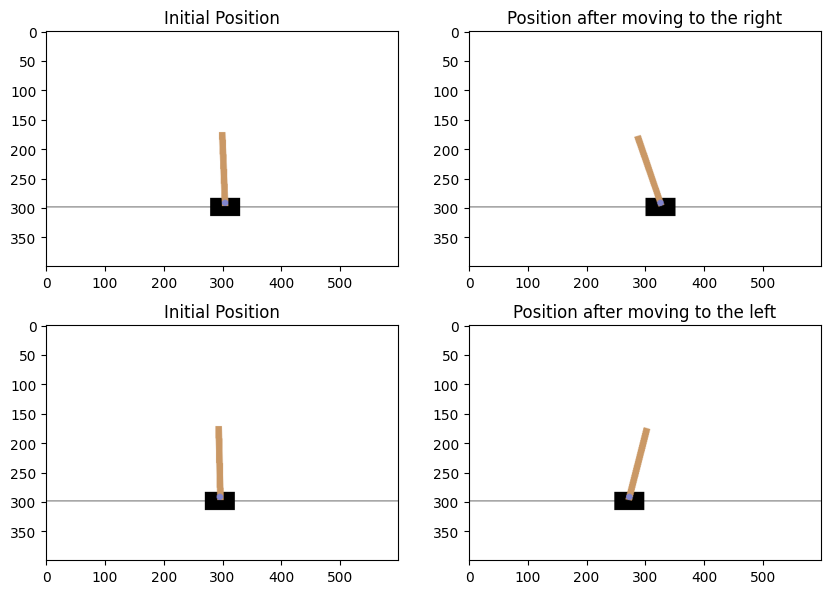

In [7]:
env.reset()
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(2,2, 1)

img = env.render()
plt.imshow(img)
plt.title("Initial Position")

fig.add_subplot(2,2, 2)
for i in range(10):
    env.step(1)
img = env.render()
plt.imshow(img)
plt.title("Position after moving to the right")

env.reset()
fig.add_subplot(2,2, 3)

img = env.render()
plt.imshow(img)
plt.title("Initial Position")

fig.add_subplot(2,2, 4)
for i in range(10):
    env.step(0)
img = env.render()
plt.imshow(img)
plt.title("Position after moving to the left")

## Deep $Q$-Learning

In [8]:
keras.backend.clear_session()
input_shape = [4]
n_outputs = 2

q_model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape = input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

t_model = keras.models.clone_model(q_model)
t_model.set_weights(q_model.get_weights())

In [9]:
### deque: linked list
from collections import deque

replay_buffer = deque(maxlen=2000)

def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

def epsilon_greedy_policy(state, epsilon=0):
    
    #exploration: acts randomly with probability epsilon
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    
    #exploitation: acts greedily with probability 1-epsilon
    else:
        Q_values = q_model.predict(state[np.newaxis], verbose=0)
        return np.argmax(Q_values[0])
#using epsilon-greedy policy
def play_one_step(env, epsilon, state):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, _, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

num_update_steps = 4
def check_update_conditions(step, memory_buffer, batch_size):
    if (step + 1) % num_update_steps == 0 and len(memory_buffer) > batch_size:
        return True
    return False

TAU =  0.99 #SOFT UPDATE PARAM
def soft_update_weights():
    for t_weights, q_weights in zip(t_model.weights, q_model.weights):
        t_weights.assign(TAU * t_weights + (1 - TAU) * q_weights)

In [ ]:
# Set the batch size for experience replay
batch_size = 32
# Discount factor for future rewards
gamma = 0.95
# Adam optimizer for training the Q-network
optimizer = keras.optimizers.Adam(learning_rate=6e-3)
# Huber loss is less sensitive to outliers than MSE
loss_fn = keras.losses.Huber()

# Performs a single training step for the Q-network using a batch of experiences
def training_step(batch_size):
    # Sample a batch of experiences (state, action, reward, next_state, done)
    experiences = sample_experiences(batch_size)
    
    # Unpack the batch into separate arrays for each component
    states, actions, rewards, next_states, dones = experiences
    
    # Predict Q-values for the next states using the current Q-network
    next_Q_values = q_model.predict(next_states, verbose=0)  # Shape: (batch_size, n_outputs)
    # For each next state, select the action with the highest Q-value
    best_next_actions = np.argmax(next_Q_values, axis=1)  # Shape: (batch_size,)
    # Create a one-hot mask for the best actions
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()  # Shape: (batch_size, n_outputs)
    # Predict Q-values for the next states using the target network, then select the best Q-value for each state
    next_best_Q_values = (t_model.predict(next_states, verbose=0) * next_mask).sum(axis=1)  # Shape: (batch_size,)
    # Compute the target Q-values using the Bellman equation:
    # target = reward + (1 - done) * gamma * next_best_Q_value
    target_Q_values = (rewards + (1 - dones) * gamma * next_best_Q_values)  # Shape: (batch_size,)
    target_Q_values = target_Q_values.reshape(-1, 1)  # Shape: (batch_size, 1)
    # Create a one-hot mask for the actions actually taken
    mask = tf.one_hot(actions, n_outputs)  # Shape: (batch_size, n_outputs)
    
    # Compute the loss and update the Q-network weights
    with tf.GradientTape() as tape:
        # Predict all Q-values for the current states
        all_Q_values = q_model(states)  # Shape: (batch_size, n_outputs)
        # Select the Q-values corresponding to the actions taken
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)  # Shape: (batch_size, 1)
        # Compute the mean Huber loss between the target and predicted Q-values
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    # Compute gradients of the loss with respect to the Q-network's trainable variables
    grads = tape.gradient(loss, q_model.trainable_variables)
    # Apply the gradients to update the Q-network
    optimizer.apply_gradients(zip(grads, q_model.trainable_variables))

In [11]:
np.random.seed(42)
tf.random.set_seed(42)

rewards = []
best_score = 0
epsilon = 1.0

In [12]:
for episode in range(0, 500):
    obs = env.reset()[0]
    epsilon = max(1 - episode / 500, 0.01)
    for step in range(200):
        obs, reward, done, info = play_one_step(env, epsilon, obs)
        if done:
            break
    
        update = check_update_conditions(step, replay_buffer, batch_size)
        #experience replay
        if update:
            training_step(batch_size)
            soft_update_weights()
            
    rewards.append(step)
    if step >= best_score:
        best_weights = q_model.get_weights()
        best_score = step
        
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="")
    epsilon = max(0.01, 0.995*epsilon)
q_model.set_weights(best_weights)

Episode: 499, Steps: 200, eps: 0.010

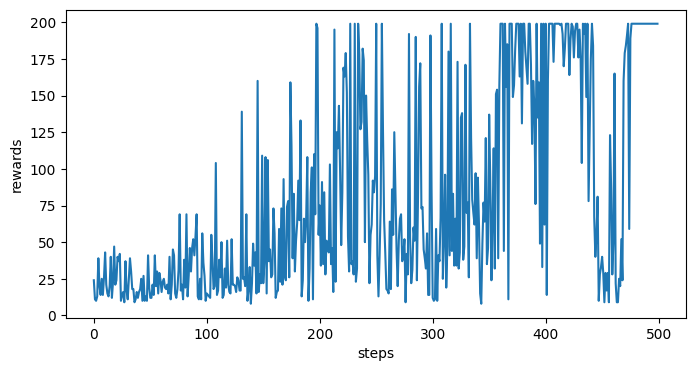

In [13]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("steps")
plt.ylabel("rewards")
plt.savefig("graph_500.png")

In [14]:
q_model.save("q_model_500")